# Describe merged sequences file

Download the `merged_results` folder as described by `README.md` in this project 
root folder. Then we can apply some statistics to the merged sequences file.

In [1]:
import csv

import biom
import Bio.SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src import project_directory

let's read the sequences file:

In [2]:
fasta_file = project_directory / "merged_results/export/rep-seqs.fasta/dna-sequences.fasta"

sequences = Bio.SeqIO.index(fasta_file, "fasta")

How many sequences are in the file?

In [3]:
len(sequences)

164694

## Describe sequence lengths

Let's measure the length of each sequence and plot a histogram of the lengths:

In [4]:
# get the lengths of all sequences
sequence_lengths = [len(record.seq) for record in sequences.values()]

Let's search for outliers in the lengths of the sequences, for example sequences
with lengths 1.5 far from IQR:

In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(sequence_lengths, 25)
Q3 = np.percentile(sequence_lengths, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = [length for length in sequence_lengths if length < lower_bound or length > upper_bound]

print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")

Lower bound for outliers: 374.5
Upper bound for outliers: 450.5


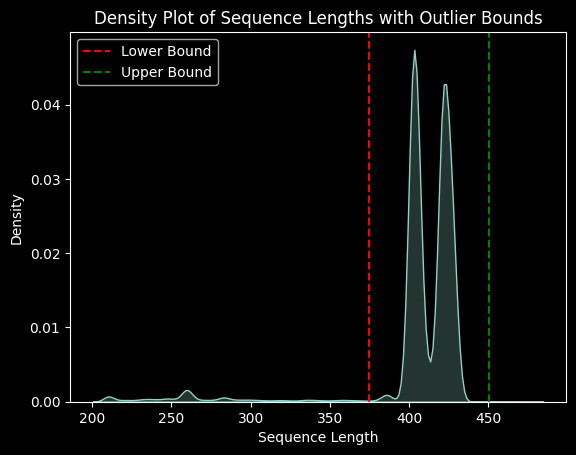

In [6]:
# Create a density plot
sns.kdeplot(sequence_lengths, fill=True)
plt.axvline(lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='g', linestyle='--', label='Upper Bound')
plt.xlabel('Sequence Length')
plt.ylabel('Density')
plt.title('Density Plot of Sequence Lengths with Outlier Bounds')
plt.legend()
plt.show()

In [7]:
num_below_lower_bound = sum(length < lower_bound for length in sequence_lengths)
print(f"Number of sequences with lengths below the lower bound: {num_below_lower_bound}")

Number of sequences with lengths below the lower bound: 9671


try to load the taxononies from file

In [8]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}

Ok try to collect the taxonomy for sequences with lengths below `lower_bound`:

In [9]:
short_sequences = {record.id: taxonomies[record.id].split(";")[:-1] for record in sequences.values() if len(record.seq) < lower_bound}

In [10]:
# Convert the short_sequences dictionary into a DataFrame
short_sequences_df = pd.DataFrame.from_dict(short_sequences, orient='index', columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Strain'])

# Display the DataFrame
short_sequences_df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Strain
00014fe9293f8f515587a4c2a3586c1b,Bacteria,,,,,,,
001e95f99f0af6b1f4e29408f00748a9,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,
0025d4637d36f24277a9040627fc1147,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Mitochondria,,,
002774e1a6f591311f22303081650d9b,Bacteria,Firmicutes,Clostridia,Oscillospirales,Hungateiclostridiaceae,Saccharofermentans,,
0028e5a85cbacf0a9af27c47e03f663c,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Fournierella,,


In [11]:
# Add a column for sequence length
short_sequences_df['Sequence Length'] = [len(sequences[seq_id].seq) for seq_id in short_sequences_df.index]

# Display the updated DataFrame
short_sequences_df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Strain,Sequence Length
00014fe9293f8f515587a4c2a3586c1b,Bacteria,,,,,,,,212
001e95f99f0af6b1f4e29408f00748a9,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,,259
0025d4637d36f24277a9040627fc1147,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Mitochondria,,,,278
002774e1a6f591311f22303081650d9b,Bacteria,Firmicutes,Clostridia,Oscillospirales,Hungateiclostridiaceae,Saccharofermentans,,,260
0028e5a85cbacf0a9af27c47e03f663c,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Fournierella,,,283


In [12]:
# Replace empty values with 'unknown'
short_sequences_df = short_sequences_df.replace('', 'Unknown')

# Display the updated DataFrame
short_sequences_df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Strain,Sequence Length
00014fe9293f8f515587a4c2a3586c1b,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,212
001e95f99f0af6b1f4e29408f00748a9,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,Unknown,Unknown,Unknown,259
0025d4637d36f24277a9040627fc1147,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Mitochondria,Unknown,Unknown,Unknown,278
002774e1a6f591311f22303081650d9b,Bacteria,Firmicutes,Clostridia,Oscillospirales,Hungateiclostridiaceae,Saccharofermentans,Unknown,Unknown,260
0028e5a85cbacf0a9af27c47e03f663c,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Fournierella,Unknown,Unknown,283


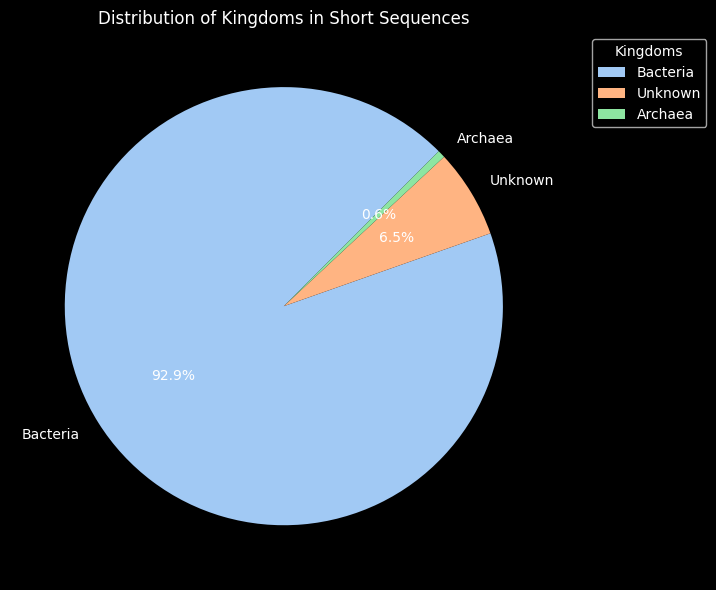

In [13]:
# Count the occurrences of each kingdom
kingdom_counts = short_sequences_df['Kingdom'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10, 6))
kingdom_counts.plot.pie(autopct='%1.1f%%', startangle=45, colors=sns.color_palette('pastel'))
plt.ylabel('')
plt.title('Distribution of Kingdoms in Short Sequences')

# Add a legend
plt.legend(kingdom_counts.index, title="Kingdoms", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


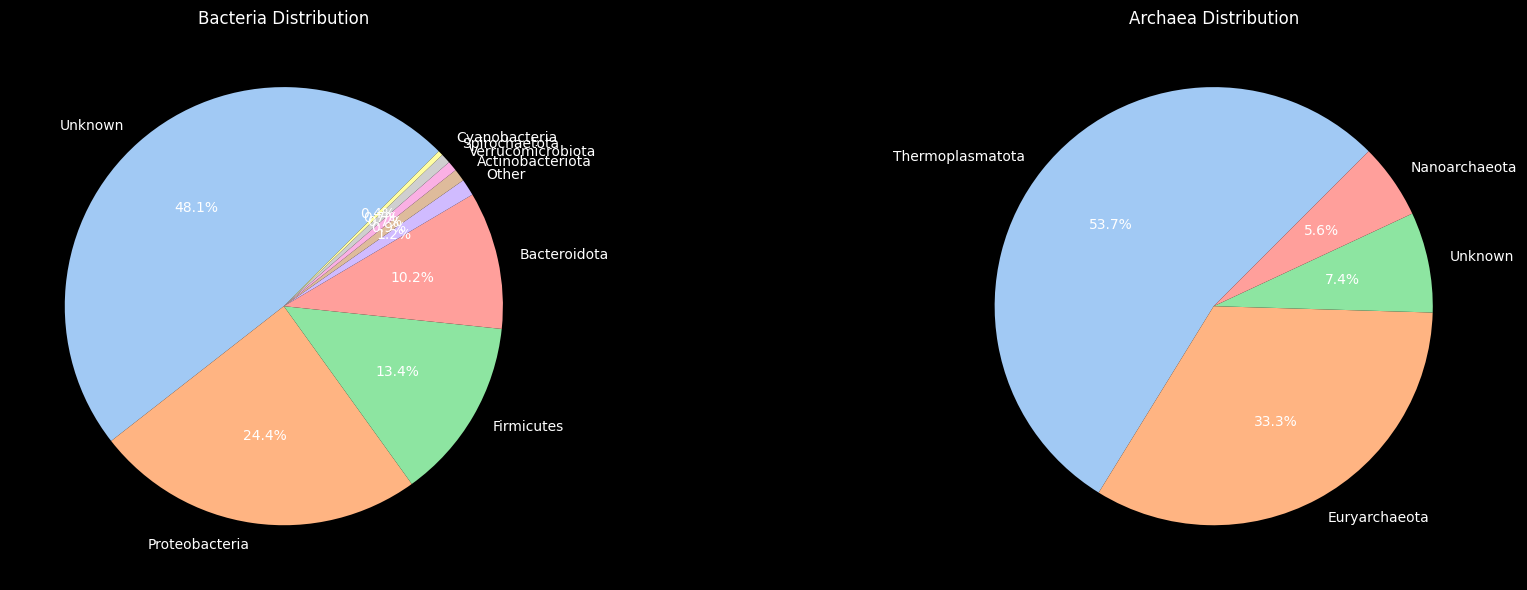

In [14]:
# Count the occurrences of each kingdom
kingdom_counts = short_sequences_df['Kingdom'].value_counts()

# drop the 'Unknown' kingdom
kingdom_counts = kingdom_counts.drop('Unknown')

# Condense values below a certain threshold
threshold = 30

def condense_values(counts, threshold):
    # return if there are a few elements
    if len(counts) <= 5:
        return counts

    # Condense values below a certain threshold
    counts = counts.to_dict()
    other_count = sum(v for v in counts.values() if v <= threshold)
    counts = {k: v for k, v in counts.items() if v > threshold}
    counts['Other'] = other_count
    return pd.Series(counts).sort_values(ascending=False)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(kingdom_counts), figsize=(20, 6))

# Plot each kingdom in a separate subplot
for ax, (kingdom, count) in zip(axes, kingdom_counts.items()):
    kingdom_data = short_sequences_df[short_sequences_df['Kingdom'] == kingdom]
    phylum_counts = kingdom_data['Phylum'].value_counts()
    phylum_counts = condense_values(phylum_counts, threshold)
    phylum_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=45, colors=sns.color_palette('pastel'))
    ax.set_ylabel('')
    ax.set_title(f'{kingdom} Distribution')

# Adjust layout
plt.tight_layout()
plt.show()

## About sample distribution

Are those short sequences prevalent in some samples? load the biom table:

In [15]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [16]:
# get the ids of the short reads
short_read_ids = short_sequences_df.index.tolist()

# Filter the table to include only rows with IDs in short_read_ids
filtered_table = table.filter(short_read_ids, axis='observation', inplace=False)
filtered_table.shape

(9671, 951)

Transform the table into a dataframe:

In [17]:
# Convert the biom table to a pandas DataFrame
filtered_table_df = filtered_table.to_dataframe(dense=True)

# Remove samples (columns) that contain only zeros
filtered_table_df = filtered_table_df.loc[:, (filtered_table_df != 0).any(axis=0)]
filtered_table_df.shape

(9671, 946)

In [18]:
# Sum the counts of short reads for each sample
short_reads_per_sample = filtered_table_df.sum(axis=0)

# Display the result
short_reads_per_sample.head()

KR9NH_sample_100     45.0
KR9NH_sample_10     146.0
KR9NH_sample_11     266.0
KR9NH_sample_12     162.0
KR9NH_sample_13     137.0
dtype: float64

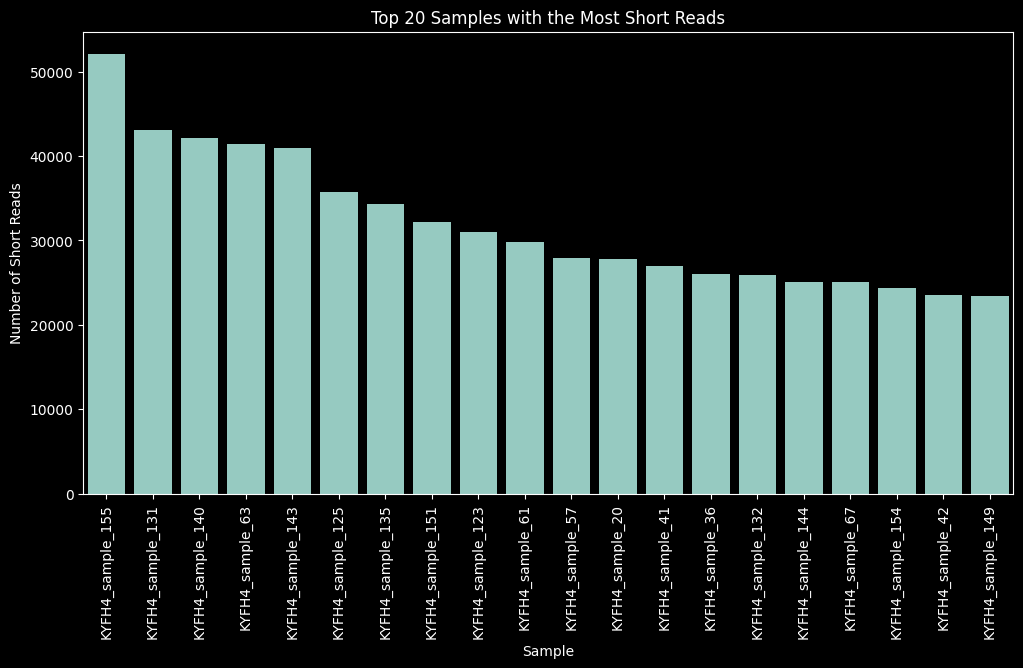

In [19]:
# Plot the short reads per sample for the top 20 samples with the most reads
top_20_samples = short_reads_per_sample.nlargest(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_samples.index, y=top_20_samples.values)
plt.xlabel('Sample')
plt.ylabel('Number of Short Reads')
plt.title('Top 20 Samples with the Most Short Reads')
plt.xticks(rotation=90)
plt.show()

Display the top 20 samples with the most short sequences:

In [20]:
# transform in DataFrame and set column names
top_20_samples_df = top_20_samples.reset_index()
top_20_samples_df.columns = ['Sample', 'Short_Reads_Count']
top_20_samples_df

,Sample,Short_Reads_Count
0,KYFH4_sample_155,52111.0
1,KYFH4_sample_131,43024.0
2,KYFH4_sample_140,42158.0
3,KYFH4_sample_63,41361.0
4,KYFH4_sample_143,40892.0
5,KYFH4_sample_125,35678.0
6,KYFH4_sample_135,34256.0
7,KYFH4_sample_151,32127.0
8,KYFH4_sample_123,30992.0
9,KYFH4_sample_61,29786.0


### Focus on KYFH4_sample_155

Let's collect the total number of counts for sample `KYFH4_sample_155`, the sample with the most
short sequences, and then explore the taxonomy of this sample:

In [21]:
counts_KYFH4_sample_155 = table.data('KYFH4_sample_155', axis='sample').sum()
counts_KYFH4_sample_155

np.float64(52170.0)

extract the taxonomy for the shorted sequences in the sample `KYFH4_sample_155`:

In [22]:
# Get the sequence IDs for the sample KYFH4_sample_155
sample_sequence_ids = filtered_table_df.index[filtered_table_df['KYFH4_sample_155'] > 0].tolist()

# Filter the short_sequences_df to include only rows with IDs in sample_sequence_ids
sample_short_sequences_df = short_sequences_df.loc[sample_sequence_ids]

# Display the DataFrame
sample_short_sequences_df.head()


,Kingdom,Phylum,Class,Order,Family,Genus,Species,Strain,Sequence Length
010244da31d052ca4c128dc25f6fca17,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,210
021b87c30e3631113a4112f1ef04143d,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,354
0242f7505751b3f00817080847bdf115,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,210
0277f2b3d0ec92846cf884242c25d050,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,256
02ac76f8abb254994a78b74c50663f94,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Mitochondria,Unknown,Unknown,Unknown,345


Display the pie chart of the taxonomy for the shorted sequences in the sample `KYFH4_sample_155`:

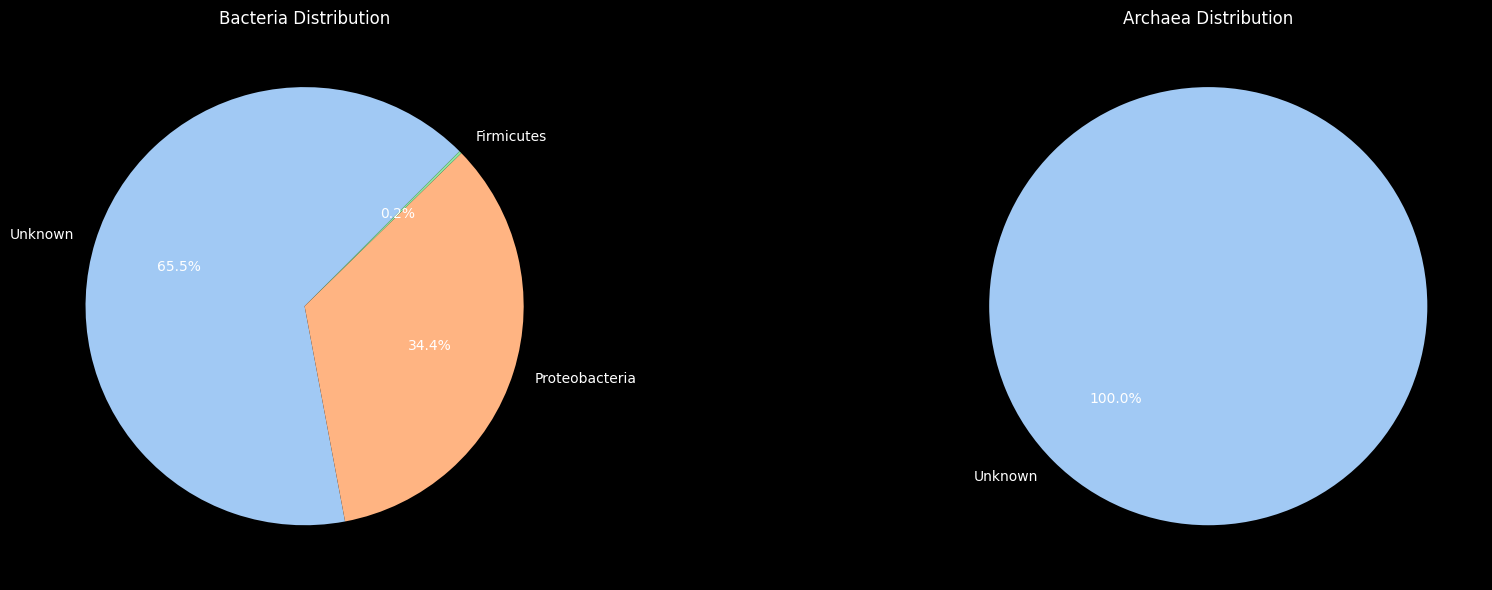

In [23]:
# Count the occurrences of each kingdom
kingdom_counts = sample_short_sequences_df['Kingdom'].value_counts()

# drop the 'Unknown' kingdom
kingdom_counts = kingdom_counts.drop('Unknown')

# Condense values below a certain threshold
threshold = 30

def condense_values(counts, threshold):
    # return if there are a few elements
    if len(counts) <= 5:
        return counts

    # Condense values below a certain threshold
    counts = counts.to_dict()
    other_count = sum(v for v in counts.values() if v <= threshold)
    counts = {k: v for k, v in counts.items() if v > threshold}
    counts['Other'] = other_count
    return pd.Series(counts).sort_values(ascending=False)

# Check the number of kingdoms
if len(kingdom_counts) == 1:
    kingdom = kingdom_counts.index[0]
    kingdom_data = sample_short_sequences_df[sample_short_sequences_df['Kingdom'] == kingdom]
    phylum_counts = kingdom_data['Phylum'].value_counts()
    phylum_counts = condense_values(phylum_counts, threshold)

    # Plot a single pie chart
    plt.figure(figsize=(10, 6))
    phylum_counts.plot.pie(autopct='%1.1f%%', startangle=45, colors=sns.color_palette('pastel'))
    plt.ylabel('')
    plt.title(f'{kingdom} Distribution')
    plt.show()

else:
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(kingdom_counts), figsize=(20, 6))

    # Plot each kingdom in a separate subplot
    for ax, (kingdom, count) in zip(axes, kingdom_counts.items()):
        kingdom_data = sample_short_sequences_df[sample_short_sequences_df['Kingdom'] == kingdom]
        phylum_counts = kingdom_data['Phylum'].value_counts()
        phylum_counts = condense_values(phylum_counts, threshold)
        phylum_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=45, colors=sns.color_palette('pastel'))
        ax.set_ylabel('')
        ax.set_title(f'{kingdom} Distribution')

    # Adjust layout
    plt.tight_layout()
    plt.show()